In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

plt.style.use("bmh")

# Introduction

## Background

Taylor Swift has been exist in music industry for more than 10 years; I've started listening to her song since I was in high school - roughly 8 years ago. Time flies, people change, and so do her songs. Her songs shifted from country to pop, and electropop on her Reputation album.

## Research Questions

Considering the various genres, can we categorize Taylor Swift's song based on its lyrics?

# Data Preparation

The song lyrics are scraped from [lyrics.com](http://lyrics.com); we use 114 Taylor Swift's song lyrics.

In [3]:
df_song = pd.read_csv("dataset/lyrics/taylor-swift.csv")
df_song = df_song.drop_duplicates(subset='title',keep='first')
df_song = df_song.loc[(df_song['artist'] == 'Taylor Swift')].copy()

In [4]:
def clean_line(series):
    series = series.replace('\n',' ').replace('\r','').replace('\t','')
    return series

cols = ['lyrics','info','credits']
for col in cols:
    df_song[col] = df_song[col].apply(clean_line)

In [5]:
df_song['year'] = df_song['info'].apply(lambda x: x.strip().split(':')[1].split(' ')[1] if ':' in x else None)
df_song['view'] = df_song['info'].apply(lambda x: x.strip().split(':')[1].split(' ')[3].strip().replace('Views','') if ':' in x else x.replace('Views','').replace(' ',''))

# remove songs with unknown release year
df_song = df_song.loc[(df_song['year'].notnull())].reset_index()

In [6]:
from collections import Counter

wc = {}

for idx, row in df_song.iterrows():
    wc[row['title']] = Counter(row['lyrics'].lower().split())

In [7]:
_l = []
for key in wc.keys():
    _l.append(len(wc[key].items()))
    
df_song['unique_word'] = _l

# Analysis

## Initial Exploration

Before 2013, Taylor Swift has more than 15 songs per release year. There is only one song in 2013 and 2015. Her earliest release year has the shortest range of unique words count per song. *Seems like she's getting more creative as her career grows?*

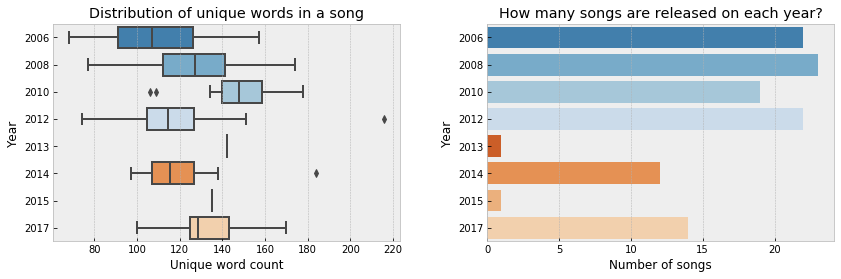

In [8]:
f, ax = plt.subplots(figsize=(14,4), ncols=2)
plt.subplots_adjust(wspace=.25)

sns.boxplot(
    data=df_song.sort_values(by='year'),
    y='year',
    x='unique_word',
    orient='h',
    palette='tab20c',
    ax=ax[0]
)

ax[0].set_title("Distribution of unique words in a song")
ax[0].set_xlabel("Unique word count")
ax[0].set_ylabel("Year")

_df = df_song.groupby('year').agg({'title':pd.Series.nunique}).reset_index()

sns.barplot(
    data=_df,
    y=_df['year'],
    x=_df['title'],
    orient='h',
    palette='tab20c',
    ax=ax[1]
)

ax[1].set_title("How many songs are released on each year?")
ax[1].set_xlabel("Number of songs")
ax[1].set_ylabel("Year")
plt.show();

In [9]:
df_song.loc[(df_song['year'].isin(['2013','2015'])),
           ['title','artist','year','unique_word']]

,title,artist,year,unique_word
11,New Romantics,Taylor Swift,2015,135
12,Sweeter Than Fiction,Taylor Swift,2013,142


Let's see common words used on one of her earliest and recent song: Fifteen (2008) and Look What You Made Me Do (2017).

Fifteen does have more unique words, and the words seem represent certain plot - see the *deep breath*, *when*, *fifteen*, *friends*, and the other words. Whereas on Look What You Made Me Do, it totally shows only a few words which are used repetitively.

Does it mean she make simpler songs recently? To verify our observation, let's check one more recent song: Gorgeous (2017). While it has more unique words than Look What You Made Me Do, we can't infer any story from the word clouds - *it's all about saying someone's face is gorgeous*.

In [10]:
from wordcloud import WordCloud, STOPWORDS 

def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(relative_scaling = 1.0,
                          background_color = 'white',
                          random_state = 101,
                          width = 1200,
                          height = 600,
                          stopwords = {'to', 'of','and','the','but','as'} # set or space-separated string
                          ).generate(text)
    f, ax = plt.subplots(figsize=(12,6))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

Fifteen


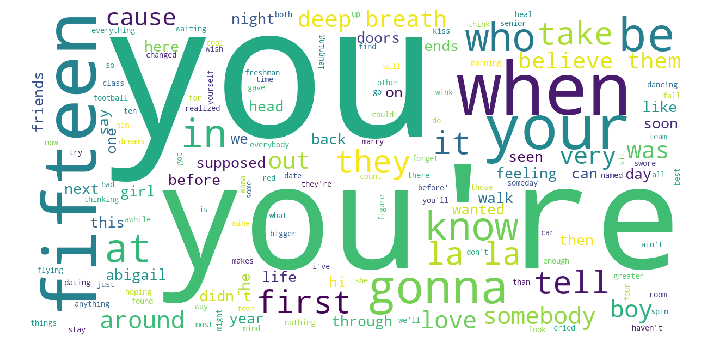

Look What You Made Me Do


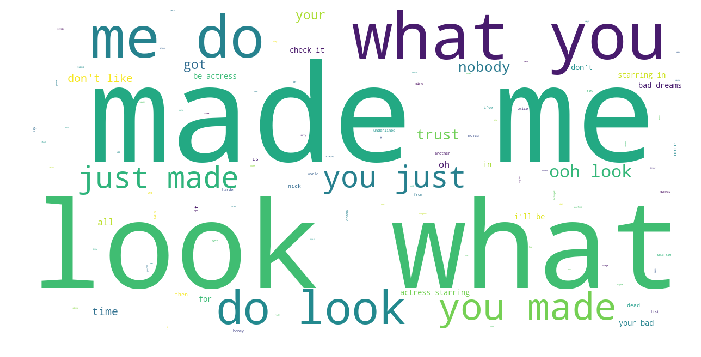

Gorgeous


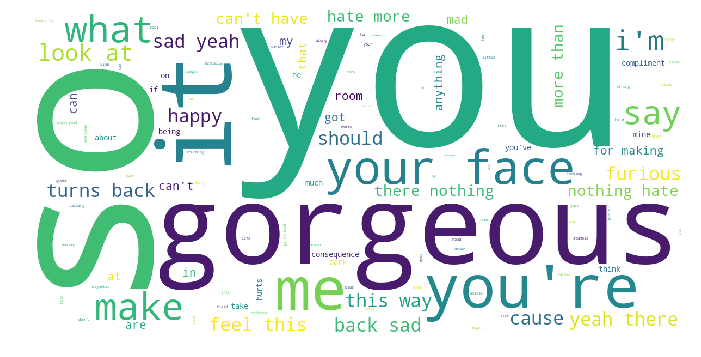

In [11]:
# create sample wordcloud for several songs
print("Fifteen")
generate_wordcloud(df_song.loc[(df_song['title'] == 'Fifteen'), 'lyrics'].values[0].lower())

print("Look What You Made Me Do")
generate_wordcloud(df_song.loc[(df_song['title'] == 'Look What You Made Me Do'), 'lyrics'].values[0].lower())

print("Gorgeous")
generate_wordcloud(df_song.loc[(df_song['title'] == 'Gorgeous'), 'lyrics'].values[0].lower())

Nah, we don't want to observe each song's word cloud and compare it one by one.. How about using more sophisticated method?

## Text Preprocessing

Here, we tokenize each words from song lyrics, remove the stop words and lemmatize the words. We use TF-IDF to determine importancy of each term - we use unigram and bigrams. There are much more less common words (rare) compared to the more common ones. The more common words are dominated by verbs (know, like, love, look).

In [12]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

from string import punctuation
from collections import Counter
import sys, re

In [13]:
from spacy.lang.en import English

nlp = English()
nlp.Defaults.stop_words.update(stop)

In [14]:
def tokenizer(text):
    return [token.lemma_.lower() for token in nlp(text) if not token.is_stop and not token.is_punct]

In [15]:
df_song['token'] = df_song['lyrics'].str.lower().map(tokenizer)

In [16]:
# store lyrics with cleaned tokens
_lyrics = []

for ix, row in df_song.iterrows():
    _txt = ''
    for word in row['token']:
        if word == ' ':
            continue
        else:
            _txt += word + ' '
    _lyrics.append(_txt.rstrip())
    
df_song['lyrics_clean'] = _lyrics

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vec = TfidfVectorizer(min_df=1, max_features=10000, analyzer='word', tokenizer=tokenizer, ngram_range=(1, 2))
vz = tfidf_vec.fit_transform(list(df_song['lyrics_clean']))

In [18]:
tfidf = dict(zip(tfidf_vec.get_feature_names(), tfidf_vec.idf_))
tfidf = pd.DataFrame(columns=['idf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['idf']

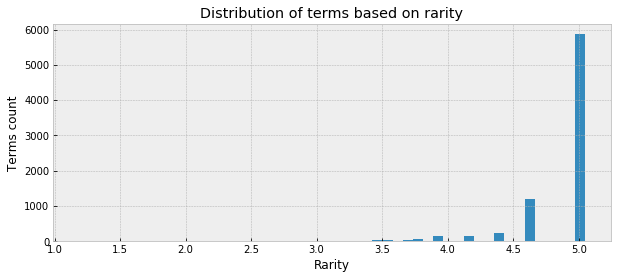

In [19]:
tfidf.idf.hist(bins=50, figsize=(10,4))
plt.xlabel("Rarity")
plt.ylabel("Terms count")
plt.title("Distribution of terms based on rarity")
plt.show()

In [20]:
print("More common terms:")
print(tfidf.sort_values(by=['idf'], ascending=True).head(10).index.values)

print("\n=========================\n")
print("Less common terms:")
print(tfidf.sort_values(by=['idf'], ascending=False).head(10).index.values)

More common terms:
['know' 'like' 'love' 'think' 'time' 'oh' 'look' 'come' 'want' 'right']


Less common terms:
['long realize' 'place spot' 'paradise fade' 'parade shake' 'parade'
 'paper lie' 'paper briefcase' 'paper airplane' 'pane think' 'pane']


## Dimensionality Reduction

After using TF-IDF, we have sparse metrics containing document-term matrix, in which its dimension equals to number of unique terms.. *Oh no, we face the curse of dimensionality!* But no worries, we could reduce its dimension so that it could be processed and visualized more easily.

In [21]:
from sklearn.decomposition import TruncatedSVD


svd = TruncatedSVD(n_components=100, random_state=101)
svd_tfidf = svd.fit_transform(vz)

In [22]:
# get number of unique tokens
_t = []

for ix, row in df_song.iterrows():
    for t in row['token']:
        if t not in _t and t != ' ':
            _t.append(t)
            
print("Number of unique tokens: {:,}".format((len(_t))))

Number of unique tokens: 1,494


In [23]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, verbose=1, random_state=101)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 114 samples in 0.000s...
[t-SNE] Computed neighbors for 114 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 114 / 114
[t-SNE] Mean sigma: 0.212743
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.797768
[t-SNE] Error after 1000 iterations: 0.786939


In [24]:
print("Dimension after TF-IDF \t: ", vz.shape)
print("Dimension after SVD \t: ", svd_tfidf.shape)
print("Dimension after t-SNE \t: ", tsne_tfidf.shape)

Dimension after TF-IDF 	:  (114, 7883)
Dimension after SVD 	:  (114, 100)
Dimension after t-SNE 	:  (114, 2)


## Clustering

Before clustering the songs, we visualize t-SNE results, as well as trying to reduce the dimension using UMAP.
It appears that **songs across the years aren't well separated**.

In [25]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.io import output_file

tsne_tfidf_df = pd.DataFrame(tsne_tfidf, columns=['x','y'])
tsne_tfidf_df['year'] = df_song['year']
tsne_tfidf_df['title'] = df_song['title']
tsne_tfidf_df['lyrics'] = df_song['lyrics']

In [26]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="tf-idf clustering",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

palette = d3['Category10'][len(tsne_tfidf_df['year'].unique())]
color_map = bmo.CategoricalColorMapper(factors=tsne_tfidf_df['year'].map(str).unique(), palette=palette)

plot_tfidf.scatter(x='x', y='y', color={'field': 'year', 'transform': color_map}, 
                   legend='year', source=tsne_tfidf_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"title":"@title", "year":"@year"}

show(plot_tfidf)

Loading BokehJS ...

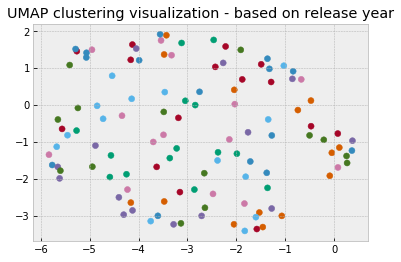

In [27]:
import umap

reducer = umap.UMAP(n_components=2,
                    n_neighbors=10,
                    random_state=101)
embedding = reducer.fit_transform(tsne_tfidf)

plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in range(0,df_song.year.nunique())])

plt.title("UMAP clustering visualization - based on release year")
plt.show();

We attempt to cluster the songs using HDBSCAN - we find that each clusters aren't well separated. Also, the third cluster only has 6 members.

Number of clusters: 3


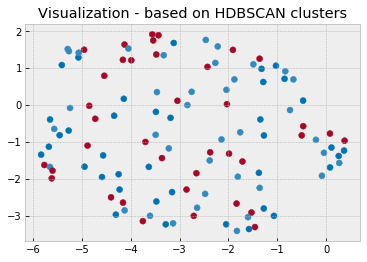

In [28]:
# from sklearn.cluster import DBSCAN
import hdbscan

# clf = DBSCAN()
clf = hdbscan.HDBSCAN()
clf.fit(tsne_tfidf)
print('Number of clusters: {}'.format(len(np.unique(clf.labels_))))

df_song['cluster'] = clf.labels_

plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in df_song['cluster'].unique()])
plt.title("Visualization - based on HDBSCAN clusters")
plt.show();

In [29]:
print("Cluster members:")
df_song['cluster'].value_counts()

Cluster members:


-1    78
 0    30
 1     6
Name: cluster, dtype: int64

## Topic Modelling

Let's see whether we could separate the songs based on its topic. Almost 60% of the songs are categorized into a topic, leaving the others into 3 other topics.

In [30]:
import lda
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

cvectorizer = CountVectorizer(min_df=2, analyzer='word', max_features=10000, tokenizer=tokenizer, ngram_range=(1,2))
cvz = cvectorizer.fit_transform(df_song['lyrics_clean'])

n_topics = 4
n_iter = 2000
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter, random_state=101)
X_topics = lda_model.fit_transform(cvz)

In [31]:
n_top_words = 10
topic_summaries = []

topic_word = lda_model.topic_word_  # get the topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: love wish time look stay wish wish good know car right
Topic 1: oh oh oh know girl clear beautiful love everybody come way
Topic 2: know like want feel think oh thing baby yes time
Topic 3: come think like ah ha know come come follow mind home


In [32]:
tsne_lda = tsne_model.fit_transform(X_topics)


doc_topic = lda_model.doc_topic_
lda_keys = []
for i, txt in enumerate(df_song['lyrics_clean']):
    lda_keys += [doc_topic[i].argmax()]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 114 samples in 0.000s...
[t-SNE] Computed neighbors for 114 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 114 / 114
[t-SNE] Mean sigma: 0.166318
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.081642
[t-SNE] Error after 1000 iterations: 0.087481


In [33]:
lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
lda_df['lyrics'] = df_song['lyrics']
lda_df['year'] = df_song['year']
lda_df['title'] = df_song['title']

lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(int)

lda_df['token'] = df_song['token']
lda_df['len_docs'] = df_song['token'].map(len)

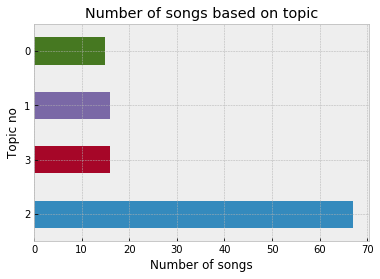

In [34]:
lda_df['topic'].value_counts().plot.barh()
plt.title("Number of songs based on topic")
plt.xlabel("Number of songs")
plt.ylabel("Topic no")
plt.show();

In [35]:
def prepareLDAData(lda_model, lda_df, cvectorizer):
    data = {
        'vocab': vocab,
        'doc_topic_dists': lda_model.doc_topic_,
        'doc_lengths': list(lda_df['len_docs']),
        'term_frequency':cvectorizer.vocabulary_,
        'topic_term_dists': lda_model.components_
    } 
    return data

In [36]:
import pyLDAvis
pyLDAvis.enable_notebook()

lda_data = prepareLDAData(lda_model=lda_model, lda_df=lda_df, cvectorizer=cvectorizer)
prepared_data = pyLDAvis.prepare(**lda_data)
pyLDAvis.display(prepared_data)

# Results and Discussions

We attempt to separate Taylor Swift's song into several categories, which ends up in rather unsatisfactory results:
- from our observations, the clusters aren't distinct
- although we can model the topics, we couldn't infer the actual topic of each groups since words on each topic are quite similar

# References

[1] Morris, C. 2017. An Exercise in Language Compression: Are pop lyrics getting more repetitive? Accessed [here](https://pudding.cool/2017/05/song-repetition/). <br/>
[2] Besbes, A. 2017. How to mine newsfeed data and extract interactive insights in Python. Accessed [here](https://ahmedbesbes.com/how-to-mine-newsfeed-data-and-extract-interactive-insights-in-python.html).